# CS 439 Final Project
## Finetuning DistillBert on Microcontroller Unit (MCU) Datasheets
Group Members: Shivam Patel (smp440), Tyler Abassi (?)

*NOTE:* Work was done on a VM equipped with a 24-core CPU and 2 L40s Nvidia GPUs. Even then, some steps, such as document OCR and model training took significant time (2 hours and 30 minutes respectively). Therefore, already processed files have been provided alongside the original code. Take note of comments and skip computationally intense cells to either load checkpoints from disk or calculate results from scratch. 

In [1]:
import os
import sys
import json
import csv
import math
import time
import requests
import torch
import umap
import numpy as np
from dotenv import load_dotenv
from sklearn.metrics.pairwise import cosine_similarity
from docling.document_converter import DocumentConverter
from docling.chunking import HybridChunker
from datasets import (
    Dataset,
    load_from_disk
    ) 
from transformers import (
    DistilBertTokenizerFast,
    DistilBertModel,
    DataCollatorForLanguageModeling,
    DistilBertTokenizerFast,
    DistilBertForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
load_dotenv()
MODEL_NAME = "distilbert-base-uncased"
OUTPUT_MODEL_DIR = "distilbert_embedbert"
CHUNKED_DOC_DIR = "chunked_datasheets"
FINETUNE_DATASET_DIR = "finetune_ready_dataset"  

## 1: Collecting Files

In [4]:
MOUSER_API_KEY = os.getenv("MOUSER_API_KEY")
MOUSER_API_ENDPOINT = "https://api.mouser.com/api/v1/search/partnumber"

# List of part number prefixes (wildcard support for various microcontrollers)
mcu_prefixes = ["PIC18*", "STM32*", "ATMEGA*", "ESP32*", "RP2040*", "LPC*", "PIC32*", "MSP430*", "CY8C4*"]

In [5]:
def query_mouser_parts(part_patterns):
    collected_parts = []
    headers = {"Content-Type": "application/json"}

    for pattern in part_patterns:
        print(f"Querying part: {pattern}")
        page = 1
        has_more = True

        while has_more:
            query_payload = {
                "SearchByPartRequest": {
                    "mouserPartNumber": pattern,
                    "partSearchOptions": "startsWith",
                    "recordsCount": 100,
                    "startingRecord": (page - 1) * 100
                }
            }

            response = requests.post(
                f"{MOUSER_API_ENDPOINT}?apiKey={MOUSER_API_KEY}",
                json=query_payload,
                headers=headers,
            )

            print(f"Response: {response.status_code}")
            if response.status_code != 200:
                print(f" API Error for {pattern}")
                break

            data = response.json()
            parts = data.get("SearchResults", {}).get("Parts", [])
            if not parts:
                print(f" No parts returned for {pattern}")
                break

            for part in parts:
                part_num = part.get("MouserPartNumber", "N/A")
                maker = part.get("Manufacturer", "Unknown")
                desc = part.get("Description", "No Description")
                datasheet = part.get("DataSheetUrl", "")
                inventory = part.get("Availability", "Unknown")
                pricing = part.get("PriceBreaks", [])
                unit_price = pricing[0]["Price"] if pricing else "N/A"

                if part_num == "N/A" or maker == "Unknown":
                    continue

                collected_parts.append({
                    "Part Number": part_num,
                    "Manufacturer": maker,
                    "Description": desc,
                    "Datasheet": datasheet,
                    "Price": unit_price,
                    "Stock": inventory,
                })

            print(f"Fetched {len(parts)} parts on page {page}")
            has_more = len(parts) == 100
            page += 1
            time.sleep(1)

    return collected_parts

def export_parts_to_csv(parts_data, output_file="microcontrollers_data.csv"):
    with open(output_file, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=parts_data[0].keys())
        writer.writeheader()
        writer.writerows(parts_data)
    print(f"Data exported to {output_file}")

In [6]:
mcu_data = query_mouser_parts(mcu_prefixes)
export_parts_to_csv(mcu_data)

Querying part: PIC18*
Response: 200
Fetched 50 parts on page 1
Querying part: STM32*
Response: 200
Fetched 50 parts on page 1
Querying part: ATMEGA*
Response: 200
Fetched 50 parts on page 1
Querying part: ESP32*
Response: 200
Fetched 50 parts on page 1
Querying part: RP2040*
Response: 403
 API Error for RP2040*
Querying part: LPC*
Response: 403
 API Error for LPC*
Querying part: PIC32*
Response: 403
 API Error for PIC32*
Querying part: MSP430*
Response: 403
 API Error for MSP430*
Querying part: CY8C4*
Response: 403
 API Error for CY8C4*
Data exported to microcontrollers_data.csv


In [8]:
os.makedirs("pdf_datasheets", exist_ok=True)

In [7]:
def fetch_datasheet_link(mouser_part):
    headers = {"Content-Type": "application/json"}
    request_payload = {
        "SearchByPartRequest": {
            "mouserPartNumber": mouser_part,
            "partSearchOptions": "exact"
        }
    }

    try:
        response = requests.post(
            f"{MOUSER_API_ENDPOINT}?apiKey={MOUSER_API_KEY}",
            json=request_payload,
            headers=headers,
            timeout=10
        )
        response.raise_for_status()
        parts_info = response.json().get("SearchResults", {}).get("Parts", [])
        for part in parts_info:
            url = part.get("DataSheetUrl")
            if url and url.startswith("http"):
                return url
    except requests.RequestException as error:
        print(f" Datasheet fetch failed: {error}")
    return None

In [9]:
def download_datasheet_pdf(url, part_id):
    if not url:
        print(f"No URL for {part_id}")
        return

    try:
        print(f"Downloading PDF for {part_id}")
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
            "Referer": "https://www.mouser.com/",  # <-- Important
            "Accept": "application/pdf",
            "Accept-Language": "en-US,en;q=0.9",
            "Connection": "keep-alive",
        }
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()

        # filename = f"pdf_datasheets/{part_id}.pdf"
        filename = os.path.join("pdf_datasheets", f"{part_id.replace('/', '_')}.pdf")
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Saved: {filename}")

    except requests.RequestException as err:
        print(f"Download failed for {url}: {err}")

In [10]:
max_files = 50
with open("microcontrollers_data.csv", newline="", encoding="utf-8") as infile:
    reader = csv.DictReader(infile)
    for idx, row in enumerate(reader):
        if idx >= max_files:
            break
        part_id = row["Part Number"]
        datasheet_url = fetch_datasheet_link(part_id)
        download_datasheet_pdf(datasheet_url, part_id)

Saved: pdf_datasheets/579-PIC18F25K20TEML.pdf
Saved: pdf_datasheets/579-PIC18F47Q43-I_P.pdf
Saved: pdf_datasheets/579-PIC18F46J50T-IPT.pdf
Saved: pdf_datasheets/579-PIC18LF2525-I_SO.pdf
Saved: pdf_datasheets/579-PIC18F2320-I_SP.pdf
Saved: pdf_datasheets/579-PIC18F47J53-I_PT.pdf
Saved: pdf_datasheets/579-PIC18F45K40-I_P.pdf
Saved: pdf_datasheets/579-PIC18F46Q10TIPT.pdf
Saved: pdf_datasheets/579-PIC18F25J50T-ISS.pdf
Saved: pdf_datasheets/579-PIC18LF43K22-IMV.pdf
Saved: pdf_datasheets/579-PIC18F45Q24TIMP.pdf
Saved: pdf_datasheets/579-PIC18F6520-I_PT.pdf
Saved: pdf_datasheets/579-PIC18LF25K42E_SS.pdf
Saved: pdf_datasheets/579-PIC18LF26K42-IML.pdf
Saved: pdf_datasheets/579-PIC18F45J10-I_ML.pdf
Saved: pdf_datasheets/579-PIC18F26K40-I_ML.pdf
Saved: pdf_datasheets/579-IC18LF24K42TI_SO.pdf
Saved: pdf_datasheets/579-PIC18LF45K42-EMV.pdf
Saved: pdf_datasheets/579-PIC18F4221-I_ML.pdf
Saved: pdf_datasheets/579-PIC18F2321-I_SO.pdf
Saved: pdf_datasheets/579-PIC18F6722-I_PT.pdf
Saved: pdf_datasheets/5

## 2: PDF-to-Text
First, we need to use [docling](https://github.com/docling-project/docling) to extract text from the pdfs.

In [ ]:
docling_input_directory = "./datasheets"

# change this if actually running the docling code yourself, but it is VERY slow!
docling_output_directory = "./chunked_datasheets" 

converter = DocumentConverter()
chunker = HybridChunker(
    tokenizer=MODEL_NAME, 
    max_tokens=256 # generall 100-300 tokens is a good range, 256 has good memory alignment
)

print('Beginning conversion of files using docling...')
for root, dirs, files in os.walk(docling_input_directory):
    for name in files:
        if not name.endswith(".pdf"):
            print(f'Skipping {name}, is not a pdf!')
            continue
        conv_res = converter.convert(os.path.join(root, name)) # This may raise length related warnings. They are lies
        chunks = list(chunker.chunk(conv_res.document))
        chunked_texts = [chunker.contextualize(chunk=chunk) for chunk in chunks]
        with open(os.path.join(docling_output_directory, os.path.splitext(name)[0]) + '.json', 'wb') as output_file:
            output_file.write(json.dumps(chunked_texts, indent=4).encode('utf-8'))

Count the total number of text segments put out by the chunker

In [11]:
count = 0
for filename in sorted(os.listdir(CHUNKED_DOC_DIR)):
    if filename.endswith(".json"):
        filepath = os.path.join(CHUNKED_DOC_DIR, filename)
        with open(filepath, "r", encoding="utf-8") as f:
            data = json.load(f)
            if isinstance(data, list):
                count += len(data)

print(f"Found {count} paragraphs in {CHUNKED_DOC_DIR}.")

Found 177203 paragraphs in chunked_datasheets.


## 3: Tokenizing and Masking Text

First we validate and load data from disk.

In [12]:
MAX_LENGTH = 512
MLM_PROB = 0.15

all_texts = []

for filename in sorted(os.listdir(CHUNKED_DOC_DIR)):
    if filename.endswith(".json"):
        filepath = os.path.join(CHUNKED_DOC_DIR, filename)
        with open(filepath, "r", encoding="utf-8") as f:
            data = json.load(f)
            if isinstance(data, list):  # Already a list of strings
                for paragraph in data:
                    if paragraph.strip():
                        all_texts.append(paragraph.strip())
            else:
                print(f"Warning: Skipping unrecognized format in {filename}")

# Should match the count above
print(f"Loaded {len(all_texts)} paragraphs from {CHUNKED_DOC_DIR}.")

Loaded 177203 paragraphs from chunked_datasheets.


Now, we tokenize.

In [13]:
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
tokenized = tokenizer(
    all_texts,
    padding="max_length",
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors="pt"
)

Now, we mask the relevant tokens.

In [14]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=MLM_PROB
)
masked_batch = data_collator([{
    "input_ids": ids,
    "attention_mask": mask
} for ids, mask in zip(tokenized["input_ids"], tokenized["attention_mask"])])

Massage the masked dataset into a Huggingface compatible dataset and save to disk.

In [15]:
masked_dataset = Dataset.from_dict({
    "input_ids": masked_batch["input_ids"].tolist(),
    "attention_mask": masked_batch["attention_mask"].tolist(),
    "labels": masked_batch["labels"].tolist()
})
os.makedirs(FINETUNE_DATASET_DIR, exist_ok=True)
masked_dataset.save_to_disk(FINETUNE_DATASET_DIR)

Saving the dataset (0/3 shards):   0%|          | 0/177203 [00:00<?, ? examples/s]

## 4: LLM Training
Let's load the dataset and split it into training (80%), validation (10%), and test (10%) sets.

In [16]:
NUM_EPOCHS = 3
PER_DEVICE_BATCH_SIZE = 64 # may need to be adjusted based on your GPU memory, 64 fits nicely on an L40s
LEARNING_RATE = 5e-5
MLM_PROBABILITY = 0.20
WARMUP_RATIO = 0.10

print(f"Loading dataset from {FINETUNE_DATASET_DIR}...")
dataset = load_from_disk(FINETUNE_DATASET_DIR)

Loading dataset from finetune_ready_dataset...


In [17]:
print("Splitting dataset into train/validation/test...")
split_dataset = dataset.train_test_split(test_size=0.1, seed=1738)
test_set = split_dataset["test"]
train_valid = split_dataset["train"].train_test_split(test_size=0.1, seed=1738)
train_set = train_valid["train"]
valid_set = train_valid["test"]

Splitting dataset into train/validation/test...


Now, we initialize some Huggingface transfomer objects to help with training.

In [18]:
print(f"Loading model and tokenizer: {MODEL_NAME}")
tokenizer2 = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForMaskedLM.from_pretrained(MODEL_NAME)

Loading model and tokenizer: distilbert-base-uncased


In [19]:
# this is not needed if you ran the masking code above
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer2,
    mlm=True,
    mlm_probability=MLM_PROBABILITY
)

In [20]:
# Do some basic math to calculate the weight warmup timings
num_training_steps = len(train_set) // (PER_DEVICE_BATCH_SIZE * 2) * NUM_EPOCHS
warmup_steps = int(num_training_steps * WARMUP_RATIO)
# Warmup helps with avoiding divergence in the first few steps

In [21]:
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    logging_dir="./logs",
    per_device_train_batch_size=PER_DEVICE_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_BATCH_SIZE,
    group_by_length=True,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type="cosine",
    max_grad_norm=1.0,
    weight_decay=0.001,
    num_train_epochs=NUM_EPOCHS,
    warmup_steps=warmup_steps,
    save_steps=5000,
    eval_steps=1000, # feel free to change this, but evaluating too often can slow down training due to memops
    logging_steps=250,
    save_total_limit=2,
    eval_strategy="steps", 
    logging_strategy="steps",
    # disable_tqdm=True, -> disabling progress bar makes it easier to read logging output if piping output to file
    prediction_loss_only=False,
    fp16=True,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    report_to="none",
    ddp_find_unused_parameters=False,
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=valid_set,
    data_collator=data_collator,
    tokenizer=tokenizer2
)

/tmp/ipykernel_587516/1793232961.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Let's evaluate on the test set the base DistillBert model before any finetuning.

In [23]:
initial_test_results = trainer.evaluate(test_set)
print(f"Initial test loss: {initial_test_results['eval_loss']:.4f}")
print(f"Initial test perplexity: {math.exp(initial_test_results['eval_loss']):.2f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Initial test loss: 3.1265
Initial test perplexity: 22.79


Now, we can train.

In [24]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss,Validation Loss
1000,1.137200,1.033390
2000,0.953700,0.888316
3000,0.897000,0.849205


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=3366, training_loss=1.1028730989706637, metrics={'train_runtime': 2539.9928, 'train_samples_per_second': 169.528, 'train_steps_per_second': 1.325, 'total_flos': 5.70807012537815e+16, 'train_loss': 1.1028730989706637, 'epoch': 3.0})

We can demonstrate improvement on the test set by evaluating the finetuned model.

In [25]:
final_test_results = trainer.evaluate(test_set)
print(f"Final test loss: {final_test_results['eval_loss']:.4f}")
print(f"Final test perplexity: {math.exp(final_test_results['eval_loss']):.2f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Final test loss: 0.8531
Final test perplexity: 2.35


We can save the model to disk.

In [ ]:
trainer.save_model(OUTPUT_MODEL_DIR)
tokenizer.save_pretrained(OUTPUT_MODEL_DIR)

## 5: Creating some visualizations.
Let's start by visualizing the losses (derived from perplexity) over time

In [27]:
# Here are some logs from our training runs, but they can be replaces manually with your own
logs = [
    {'loss': 2.0593, 'grad_norm': 139336.03125, 'learning_rate': 3.705357142857143e-05, 'epoch': 0.22281639928698752}, 
    {'loss': 1.4341, 'grad_norm': 110858.5390625, 'learning_rate': 4.964382308480099e-05, 'epoch': 0.44563279857397503}, 
    {'loss': 1.2431, 'grad_norm': 108950.2421875, 'learning_rate': 4.774275727268255e-05, 'epoch': 0.6684491978609626}, 
    {'loss': 1.1395, 'grad_norm': 110304.96875, 'learning_rate': 4.4322177730535374e-05, 'epoch': 0.8912655971479501}, 
    {'eval_loss': 1.0290089845657349, 'eval_runtime': 48.5084, 'eval_samples_per_second': 328.788, 'eval_steps_per_second': 2.577, 'epoch': 0.8912655971479501}, 
    {'loss': 1.0617, 'grad_norm': 102315.7890625, 'learning_rate': 3.9610623923325374e-05, 'epoch': 1.1140819964349375}, 
    {'loss': 1.0185, 'grad_norm': 91181.7109375, 'learning_rate': 3.3922889286781825e-05, 'epoch': 1.3368983957219251}, 
    {'loss': 0.9772, 'grad_norm': 96726.6171875, 'learning_rate': 2.7638988907438168e-05, 'epoch': 1.5597147950089125}, 
    {'loss': 0.955, 'grad_norm': 86583.3203125, 'learning_rate': 2.1178769543102204e-05, 'epoch': 1.7825311942959001}, 
    {'eval_loss': 0.8887742161750793, 'eval_runtime': 48.4652, 'eval_samples_per_second': 329.082, 'eval_steps_per_second': 2.579, 'epoch': 1.7825311942959001}, 
    {'loss': 0.9353, 'grad_norm': 91750.0078125, 'learning_rate': 1.4973858366566079e-05, 'epoch': 2.0053475935828877}, 
    {'loss': 0.9116, 'grad_norm': 93331.09375, 'learning_rate': 9.438824623471798e-06, 'epoch': 2.228163992869875}, 
    {'loss': 0.9049, 'grad_norm': 98651.625, 'learning_rate': 4.943480982879786e-06, 'epoch': 2.450980392156863}, 
    {'loss': 0.8984, 'grad_norm': 88566.15625, 'learning_rate': 1.7881752127047735e-06, 'epoch': 2.6737967914438503}, 
    {'eval_loss': 0.8425655364990234, 'eval_runtime': 48.1855, 'eval_samples_per_second': 330.992, 'eval_steps_per_second': 2.594, 'epoch': 2.6737967914438503}, 
    {'loss': 0.9069, 'grad_norm': 91749.6484375, 'learning_rate': 1.83723019359755e-07, 'epoch': 2.8966131907308377}
]

test_losses = [
    {'eval_loss': 3.132037401199341, 'eval_runtime': 53.0616, 'eval_samples_per_second': 333.97, 'eval_steps_per_second': 2.62, 'epoch': 0.0},
    {'eval_loss': 0.8539559245109558, 'eval_runtime': 53.4505, 'eval_samples_per_second': 331.541, 'eval_steps_per_second': 2.601, 'epoch': 3.0}
]

Parse the logs to get the loss and epoch number

In [28]:
train_epochs, train_losses = [], []
val_epochs, val_losses = [], []
for entry in logs:
    if 'eval_loss' in entry and 'epoch' in entry:
        val_epochs.append(entry['epoch'])
        val_losses.append(entry['eval_loss'])
    elif 'loss' in entry:
        train_epochs.append(entry['epoch'])
        train_losses.append(entry['loss'])
test_epochs = [t['epoch'] for t in test_losses]
test_vals = [t['eval_loss'] for t in test_losses]

We can now make visualizations.

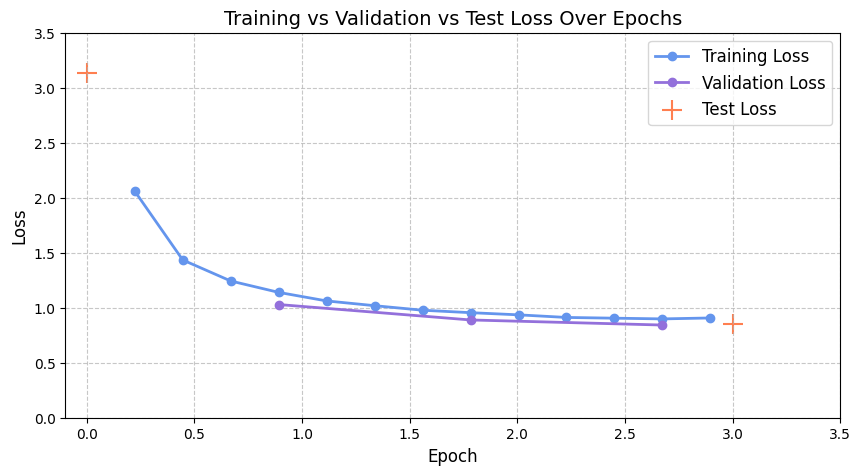

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_losses, marker='o', color='cornflowerblue', linewidth=2, label='Training Loss')
plt.plot(val_epochs, val_losses, marker='o', color='mediumpurple', linewidth=2, label='Validation Loss')
plt.scatter(test_epochs, test_vals, marker='+', s=200, color='coral', label='Test Loss')
plt.xlim(-0.1, 3.5)
plt.ylim(0, 3.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Validation vs Test Loss Over Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

# optionally save the plot
plt.savefig('loss_plot.png', dpi=300, bbox_inches='tight')

Now, let's visualize the distribution of embedding similarity. This gives us a general indication of the model is picking up in the differences between texts in the same niche.

*Note:* If you cancelled training part way through, CUDA allocated memory will not be freed correctly, so you may need to restart the notebook to run from disk.

In [ ]:
SAMPLE_SIZE = 1000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = load_from_disk(FINETUNE_DATASET_DIR)
batch = dataset[:SAMPLE_SIZE]
input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"] 

In [44]:
base_model = DistilBertModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()
fine_tuned_model = DistilBertModel.from_pretrained(OUTPUT_MODEL_DIR).to(DEVICE).eval()

In [45]:
@torch.no_grad() # save computation time by skipping gradient/backprop calculations
def get_embeddings_from_tokens(input_ids, attention_mask, model):
    # convert to tensors
    ids_tensor  = torch.tensor(input_ids, device=DEVICE)
    mask_tensor = torch.tensor(attention_mask, device=DEVICE)
    outputs = model(input_ids=ids_tensor, attention_mask=mask_tensor)
    # take the [CLS] token embedding
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

We use the helper functions to calculate the similarity between the embeddings for each text and those of all other texts using both models. 

In [46]:
base_embeds = get_embeddings_from_tokens(input_ids, attention_mask, base_model)
fine_embeds = get_embeddings_from_tokens(input_ids, attention_mask, fine_tuned_model)

cos_sim_base = cosine_similarity(base_embeds)
cos_sim_fine = cosine_similarity(fine_embeds)

# cosine similarity is symmetric, so we only need the upper triangle, also exclude the diagonal
utri_idx   = np.triu_indices_from(cos_sim_base, k=1)
base_vals  = cos_sim_base[utri_idx]
fine_vals  = cos_sim_fine[utri_idx]

Visualize.

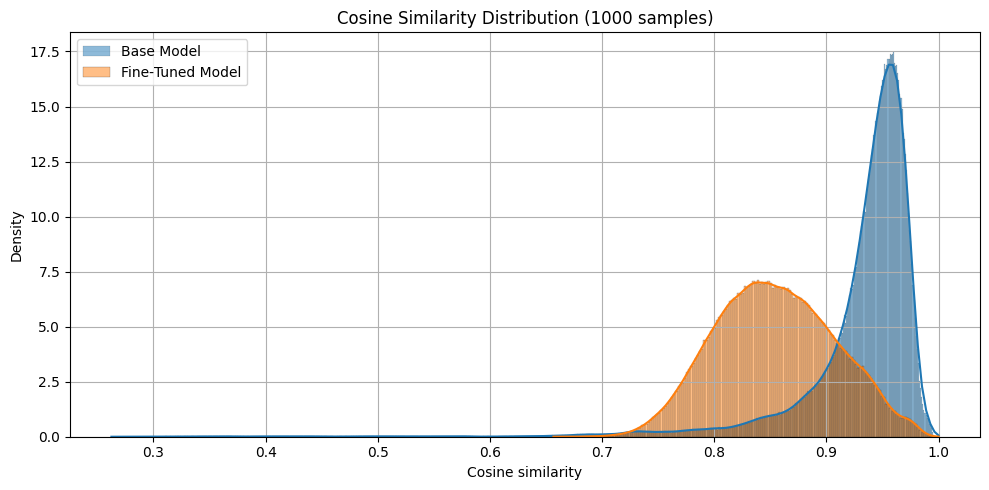

In [47]:
plt.figure(figsize=(10, 5))
sns.histplot(base_vals, label="Base Model", kde=True, stat="density", alpha=0.5)
sns.histplot(fine_vals, label="Fine‑Tuned Model", kde=True, stat="density", alpha=0.5)
plt.title("Cosine Similarity Distribution (1000 samples)")
plt.xlabel("Cosine similarity")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()

# optionally save the plot
plt.savefig("cosine_similarity_histogram.png")

We can visualize the embeddings using UMAP to see if the finetuned model is better at mapping domain specific textual similarity from the raw text to the embeddings space. We should see the finetuned model have more diverse and locally clustered embeddings compared to the base model.

In [48]:
reducer   = umap.UMAP(n_neighbors=8, min_dist=0.1, metric="cosine")
all_embeds = np.vstack([base_embeds, fine_embeds]) # faster
umap_proj  = reducer.fit_transform(all_embeds)

umap_base = umap_proj[:SAMPLE_SIZE]
umap_fine = umap_proj[SAMPLE_SIZE:]

/home/spatel/finetuning/MCUBERT/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


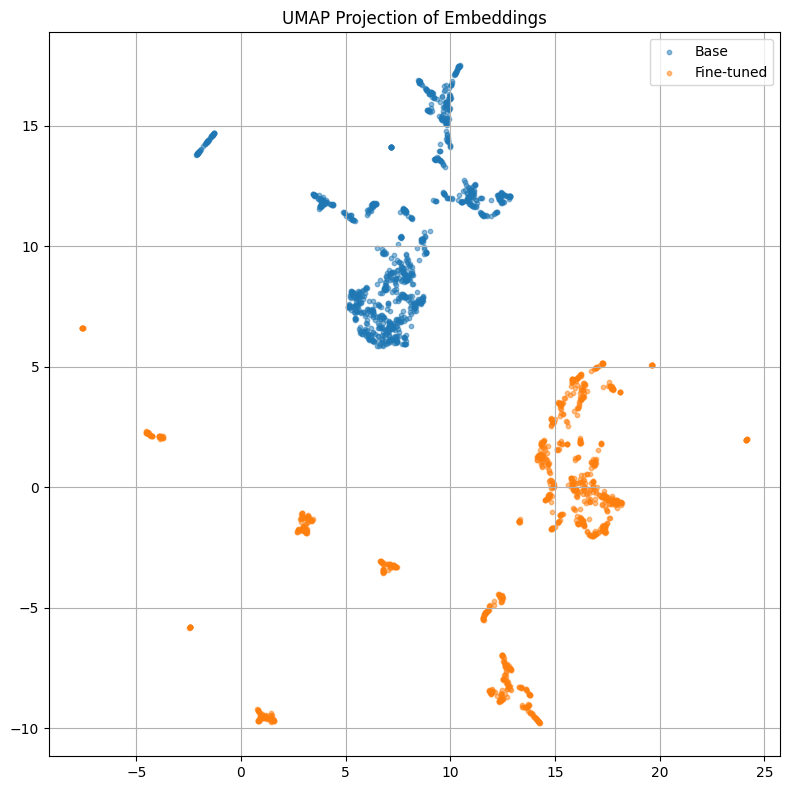

In [49]:
plt.figure(figsize=(8, 8))
plt.scatter(umap_base[:, 0], umap_base[:, 1], alpha=0.5, label="Base", s=10)
plt.scatter(umap_fine[:, 0], umap_fine[:, 1], alpha=0.5, label="Fine‑tuned", s=10)
plt.title("UMAP Projection of Embeddings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("umap_projection.png")